# DIRAC × DBiT-seq Reproducibility Demo (version-pinned to 0.1.1.post1)

> This tutorial reproduces our **DBiT-seq** integration results using **DIRAC v0.1.1.post1**.  
> The current DIRAC version is **0.1.8**; APIs differ slightly. We therefore **pin the older version** for perfect reproducibility and note key compatibility tips for 0.1.8 at the end.

---

## Table of Contents

- [Overview](#overview)
- [Environment & Version Pinning](#env)
- [Data & Layout](#data)
- [Step-by-Step Pipeline](#steps)
  - [1) Imports, seed, palette](#step1)
  - [2) Load data & basic metadata](#step2)
  - [3) Preprocess (RNA & Protein)](#step3)
  - [4) Spatial graph (BallTree, radius + k)](#step4)
  - [5) Pack data & train DIRAC](#step5)
  - [6) Neighbors, clustering, spatial plot, save](#step6)
- [Notes & Tuning](#notes)
- [Version Compatibility (0.1.1.post1 ↔ 0.1.8)](#compat)

---


## Overview

- **Goal:** Integrate **RNA** and **Protein (ADT)** from a DBiT-seq sample, learn a **shared embedding**, and identify spatial domains.  
- **Key choices in this reproducible run:**  
  - Old API (DIRAC **0.1.1.post1**) with a **BallTree radius graph** and **GCN** backbone.  
  - RNA: HVGs (Seurat v3), PCA(30); ADT: standardize.  
  - Train 500 epochs; then Leiden clustering on the learned embedding.

---

## Environment & Version Pinning

- Python ≥ 3.9 
- Packages: `scanpy`, `anndata`, `numpy`, `pandas`, `matplotlib`, `torch`, `sodirac_test==0.1.1.post1` (older DIRAC API)

**Recommended install (example):**
    pip install "sodirac_test==0.1.1.post1" scanpy anndata numpy pandas matplotlib torch

> If you already have 0.1.8 installed, consider a fresh environment to avoid API drift.

---


## Data & Layout

- Expected input files under `data_path` (example below uses `/home/project/11003054/changxu/Data/DBit_seq`):
  - `{data_name}_RNA.h5ad`
  - `{data_name}_Protein.h5ad`
- This demo uses `data_name = "0725"`.

---


## Step-by-Step Pipeline

### 1) Imports, seed, palette

In [1]:
import os 
import pandas as pd 
import numpy as np 
import torch
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

######## load dirac
import sodirac_test as sd
sd.utils.seed_torch(seed=0)

colormaps= ["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#A65628", "#FFFF33", "#F781BF", "#999999", 
            "#E5D8BD", "#B3CDE3", "#CCEBC5", "#FED9A6", "#FBB4AE", "#8DD3C7", "#BEBADA", "#80B1D3", "#B3DE69", "#FCCDE5", 
            "#BC80BD", "#FFED6F", "#8DA0CB", "#E78AC3", "#E5C494", "#CCCCCC", "#FB9A99", "#E31A1C", "#CAB2D6","#6A3D9A", "#B15928"]

data_path = "/home/project/11003054/changxu/Data/DBit_seq"
data_name = "0725"
methods = "DIRAC"

[easydl] tensorflow not available!


### 2) Load data & basic metadata

In [2]:
adata_RNA = sc.read(os.path.join(data_path, f"{data_name}_RNA.h5ad"))
adata_Protein = sc.read(os.path.join(data_path, f"{data_name}_Protein.h5ad"))
adata_RNA.raw = adata_RNA
adata_Protein.raw = adata_Protein

# number of clusters guided by ground truth (if available)
n_clusters = len(adata_RNA.obs["ground_truth"].unique())

# tag modality for diagnostics (optional)
adata_RNA.obs["Omics"] = data_name + "_mRNA"
adata_RNA.obs["Omics"] = adata_RNA.obs["Omics"].astype("category")
adata_Protein.obs["Omics"] = data_name + "_Protein"
adata_Protein.obs["Omics"] = adata_Protein.obs["Omics"].astype("category")

### 3) Preprocess (RNA & Protein)

In [3]:
# RNA: filter → normalize → log1p → HVGs (Seurat v3) → scale → PCA(30)
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)
sc.pp.highly_variable_genes(adata_RNA, n_top_genes=3000, subset=True, flavor="seurat_v3")
sc.pp.scale(adata_RNA)
sc.tl.pca(adata_RNA, n_comps=30)  # -> adata_RNA.obsm['X_pca']

# ADT/Protein: standardization
sc.pp.normalize_total(adata_Protein)
sc.pp.log1p(adata_Protein)
sc.pp.scale(adata_Protein)

### 4) Spatial graph (BallTree, radius + k)

In [4]:
# Build adjacency with BallTree + radius, plus kNN fallback inside the graph builder
# rad_cutoff is in "spatial coordinate units" (DBiT-seq pixel units). Tune if neighborhoods are too sparse/dense.
adj = sd.adj.graph(
        data=adata_RNA.obsm["spatial"],
        rad_cutoff=1.5,
        k=8,
        distType="BallTree"
    ).main()["adj_norm"]

# Convert normalized adjacency to COO and then to edge_index (PyTorch geometric style)
row, col, edge_attr = adj.t().coo()
edge_index = torch.stack([row, col], dim=0)

# prepare batch/domain labels (required by old API)
# Here we treat each modality as a separate domain; batches align with 'Omics' categories
y = pd.Categorical(
        np.array(adata_RNA.obs["Omics"]),
        categories=np.unique(adata_RNA.obs["Omics"])
    ).codes

### 5) Pack data & train DIRAC

In [5]:
save_path = os.path.join("./Results", f"{data_name}_{methods}")
os.makedirs(save_path, exist_ok=True)

# Initialize old integrate_app
unsuper = sd.main.integrate_app(save_path=save_path, use_gpu=True, subgraph=False)

# Package datasets; note batch_list/domain_list usage in 0.1.1.post1
samples = unsuper._get_data(
        dataset_list=[adata_RNA.obsm["X_pca"].copy(), adata_Protein.X.copy()],
        batch_list=[y, y],
        domain_list=[np.zeros(adata_RNA.shape[0]), np.ones(adata_Protein.shape[0])],
        edge_index=edge_index
    )

# Model: GCN, smaller dims per the original reproduction
models = unsuper._get_model(samples, n_hiddens=64, n_outputs=16, opt_GNN="GCN")

# Train; note the older API returns (data_z, combine_recon, now_timestamp)
data_z, combine_recon, now = unsuper._train_dirac_integrate(
        samples=samples,
        models=models,
        epochs=500,
        lamb=5e-3,
        scale_loss=0.05,
        lr = 1e-3, 
        wd = 5e-2,
    )

# Attach the learned joint embedding
adata_RNA.obsm["combine_recon"] = combine_recon
adata_Protein.obsm["combine_recon"] = combine_recon

Found 2 unique domains.


Project..: 100%|█| 500/500 [00:07<00:


### 6) Neighbors, clustering, spatial plot, save

Best resolution:  0.5800000000000002


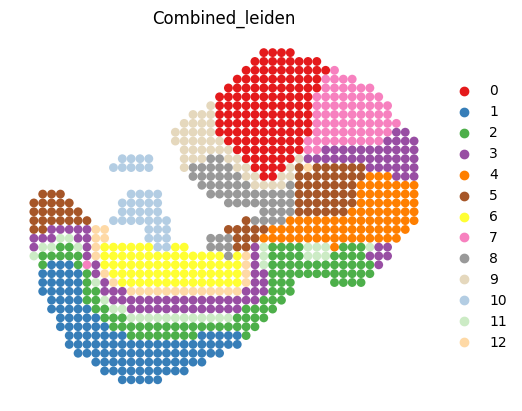

In [6]:
# Neighborhood graph on the joint embedding, then Leiden with automatic resolution
sc.pp.neighbors(adata_RNA, use_rep="combine_recon")
res = sd.utils._priori_cluster(adata_RNA, eval_cluster_n=n_clusters)
sc.tl.leiden(adata_RNA, resolution=res, key_added="Combined_leiden")

# Spatial plot
sc.pl.spatial(
        adata_RNA,
        color=["Combined_leiden"],
        palette=colormaps,
        frameon=False,
        spot_size=1,
        show=False
    )
plt.savefig(
        os.path.join(save_path, f"{data_name}_{methods}_Combined_spatial_{now}.pdf"),
        bbox_inches="tight", dpi=300
)

---
## Notes & Tuning

- **Radius vs k**: If neighborhoods are too sparse (many isolated nodes), **increase** `rad_cutoff` or `k`. If oversmoothed boundaries, **decrease** slightly.  
- **Embedding size**: `n_hiddens=64`, `n_outputs=16` are lightweight and reproduce our run; larger tissues may benefit from 128/64.  
- **Epochs**: 300–600 typical here. If convergence is slow/unstable, try a slightly smaller `lr` (if exposed) or more epochs.  
- **Clusters**: Using ground-truth layer count as a target is convenient; otherwise grid-search `resolution` or use `_priori_cluster`.  
- **Saving artifacts**: You can also write H5AD with the embedding and cluster labels, and keep a CSV export if needed.

---

## Version Compatibility (0.1.1.post1 ↔ 0.1.8)

- **Package name**: Your code imports `sodirac_test`. If you use ≥0.1.8 and the package name is `sodirac`, update imports accordingly.
- **Graph utilities**: Newer DIRAC often exposes simpler helpers (e.g., `sd.utils.get_single_edge_index`). If `sd.adj.graph(...).main()` is unavailable, switch to the newer API with a comparable k/radius setting.
- **Training return values**: In 0.1.1.post1, `_train_dirac_integrate(...)` returns **three** values `(data_z, combine_recon, now)`. Recent versions may return **two**; adjust unpacking accordingly.
- **Sampler arguments**: `batch_list` / `domain_list` handling may differ. If you move to 0.1.8, check the signature of `_get_data(...)` and remove/rename arguments as needed.
- **Defaults**: Learning-rate/weight-decay defaults may have changed. If results look different, set them explicitly to match the old behavior.

> If your goal is strict reproduction, **pin** `sodirac_test==0.1.1.post1` and run this tutorial as-is. For new projects on 0.1.8, keep the overall logic but update the graph builder and training calls per the latest docs.